In [1]:

import os
import sys
from collections import defaultdict
import gzip
import pandas as pd
import re
import csv
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

GTF_HEADER  = ['seqname', 'source', 'feature', 'start', 'end', 'score',
               'strand', 'frame']
R_SEMICOLON = re.compile(r'\s*;\s*')
R_COMMA     = re.compile(r'\s*,\s*')
R_KEYVALUE  = re.compile(r'(\s+|\s*=\s*)')


def dataframe(filename):
    """Open an optionally gzipped GTF file and return a pandas.DataFrame.
    """
    # Each column is a list stored as a value in this dict.
    result = defaultdict(list)

    for i, line in enumerate(lines(filename)):
        for key in line.keys():
            # This key has not been seen yet, so set it to None for all
            # previous lines.
            if key not in result:
                result[key] = [None] * i

        # Ensure this row has some value for each column.
        for key in result.keys():
            result[key].append(line.get(key, None))

    return pd.DataFrame(result)


def lines(filename):
    """Open an optionally gzipped GTF file and generate a dict for each line.
    """
    fn_open = gzip.open if filename.endswith('.gz') else open

    with fn_open(filename) as fh:
        for line in fh:
            if line.startswith('#'):
                continue
            else:
                yield parse(line)


def parse(line):
    """Parse a single GTF line and return a dict.
    """
    result = {}

    fields = line.rstrip().split('\t')

    for i, col in enumerate(GTF_HEADER):
        result[col] = _get_value(fields[i])

    # INFO field consists of "key1=value;key2=value;...".
    infos = [x for x in re.split(R_SEMICOLON, fields[8]) if x.strip()]

    for i, info in enumerate(infos, 1):
        # It should be key="value".
        try:
            key, _, value = re.split(R_KEYVALUE, info, 1)
        # But sometimes it is just "value".
        except ValueError:
            key = 'INFO{}'.format(i)
            value = info
        # Ignore the field if there is no value.
        if value:
            result[key] = _get_value(value)

    return result


def _get_value(value):
    if not value:
        return None

    # Strip double and single quotes.
    value = value.strip('"\'')

    # Return a list if the value has a comma.
    if ',' in value:
        value = re.split(R_COMMA, value)
    # These values are equivalent to None.
    elif value in ['', '.', 'NA']:
        return None

    return value



The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
species={'mouse':'/wynton/group/ye/mtschmitz/refdata2/mm10/Mus_musculus.GRCm38.100.gtf',
        'human':'/wynton/group/ye/mtschmitz/refdata2/hg38/gencodev33/gencode.v33.annotation.gtf',
        'macaque':'/wynton/group/ye/mtschmitz/refdata2/rhemac10/CAT_chang/Rhesus.gtf',
         'cow':'/wynton/group/ye/mtschmitz/refdata2/cetaceans/bosTau/genome/exon_sorted.gtf'}

In [3]:
feature_names={'mouse':'exon',
        'human':'exon',
        'macaque':'transcript',
         'cow':'exon'}

In [4]:
gtfs={}
for k in species.keys():
    print(k)
    gtfs[k] = dataframe(species[k])


mouse
human
macaque
cow


In [5]:
gtfs['human'] = dataframe('/wynton/group/ye/mtschmitz/refdata2/hg38/gencodev33/gencode.v33.annotation.gtf')

In [6]:
gtfs['human']

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,...,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
0,chr1,HAVANA,gene,11869,14409,None,+,None,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,None,None,None,None,None,None,None,None,None,None
1,chr1,HAVANA,transcript,11869,14409,None,+,None,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,None,None,None,None,None
2,chr1,HAVANA,exon,11869,12227,None,+,None,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,1,ENSE00002234944.1,None,None,None
3,chr1,HAVANA,exon,12613,12721,None,+,None,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,2,ENSE00003582793.1,None,None,None
4,chr1,HAVANA,exon,13221,14409,None,+,None,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,3,ENSE00002312635.1,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2909527,chrM,ENSEMBL,transcript,15888,15953,None,+,None,ENSG00000210195.2,Mt_tRNA,...,Mt_tRNA,MT-TT-201,None,basic,None,None,None,None,None,None
2909528,chrM,ENSEMBL,exon,15888,15953,None,+,None,ENSG00000210195.2,Mt_tRNA,...,Mt_tRNA,MT-TT-201,None,basic,None,1,ENSE00001544475.2,None,None,None
2909529,chrM,ENSEMBL,gene,15956,16023,None,-,None,ENSG00000210196.2,Mt_tRNA,...,None,None,None,None,None,None,None,None,None,None
2909530,chrM,ENSEMBL,transcript,15956,16023,None,-,None,ENSG00000210196.2,Mt_tRNA,...,Mt_tRNA,MT-TP-201,None,basic,None,None,None,None,None,None


In [7]:
orthos=pd.read_csv('/wynton/home/ye/mschmitz1/utils/HOM_AllOrganism.rpt',sep='\t')
orthos=orthos.loc[orthos['NCBI Taxon ID'].isin([10090,9606]),:]
classcounts=orthos['DB Class Key'].value_counts()
one2one=classcounts.index[list(classcounts==2)]
orthos=orthos.loc[orthos['DB Class Key'].isin(one2one),:]

htab=orthos.loc[orthos['NCBI Taxon ID']==9606,:]
mtab=orthos.loc[orthos['NCBI Taxon ID']==10090,:]
genemapping=dict(zip([x.upper() for x in mtab['Symbol']],htab['Symbol']))


In [8]:
for k in gtfs.keys():
    print(gtfs[k].columns)


Index(['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand',
       'frame', 'gene_id', 'gene_version', 'gene_name', 'gene_source',
       'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id',
       'transcript_version', 'transcript_name', 'transcript_source',
       'transcript_biotype', 'havana_transcript', 'havana_transcript_version',
       'tag', 'transcript_support_level', 'exon_number', 'exon_id',
       'exon_version', 'ccds_id', 'protein_id', 'protein_version'],
      dtype='object')
Index(['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand',
       'frame', 'gene_id', 'gene_type', 'gene_name', 'level', 'hgnc_id',
       'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name',
       'transcript_support_level', 'tag', 'havana_transcript', 'exon_number',
       'exon_id', 'ont', 'protein_id', 'ccdsid'],
      dtype='object')
Index(['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand',
       'frame', 'transc

In [9]:
transcript_gtfs={}
for k in gtfs.keys():
    transcript_gtfs[k]=gtfs[k].loc[gtfs[k]['feature']==feature_names[k],['seqname','start','feature','gene_name']]


In [10]:
for k in gtfs.keys():
    transcript_gtfs[k]=transcript_gtfs[k].loc[~transcript_gtfs[k]['gene_name'].duplicated(),:]



In [11]:
#convert mouse ids to standard ids
transcript_gtfs['mouse']['gene_name']=transcript_gtfs['mouse']['gene_name'].str.upper().replace(genemapping)

In [12]:
for k in transcript_gtfs.keys():
    print(transcript_gtfs[k])

            seqname    start feature       gene_name
2                 1  3073253    exon   4933401J01RIK
5                 1  3102016    exon         GM26206
8                 1  3213609    exon            XKR4
26                1  3252757    exon         GM18956
29                1  3365731    exon         GM37180
...             ...      ...     ...             ...
1869535  GL456385.1    32719    exon  CAAA01205117.1
1869538  GL456372.1    13262    exon  CAAA01098150.1
1869541  GL456381.1    16623    exon  CAAA01064564.1
1869544  JH584292.1     3536    exon        VMN2R122
1869620  JH584295.1     1440    exon  CAAA01147332.1

[55367 rows x 4 columns]
        seqname  start feature    gene_name
2          chr1  11869    exon      DDX11L1
14         chr1  29534    exon       WASH7P
27         chr1  17369    exon    MIR6859-1
30         chr1  29554    exon  MIR1302-2HG
38         chr1  30366    exon    MIR1302-2
...         ...    ...     ...          ...
2909515    chrM  14149    exon

In [13]:
for k in transcript_gtfs.keys():
    print(transcript_gtfs[k]['gene_name'].unique())


['4933401J01RIK' 'GM26206' 'XKR4' ... 'CAAA01064564.1' 'VMN2R122'
 'CAAA01147332.1']
['DDX11L1' 'WASH7P' 'MIR6859-1' ... 'MT-CYB' 'MT-TT' 'MT-TP']
['PGBD2' 'RNU6-1205P' 'AL672291.1' ... 'Rhesus_G0066377' 'Rhesus_G0066379'
 'Rhesus_G0066378']
[None '5S_rRNA' 'RCAN1' ... 'GYG2' 'XG' 'CD99']


In [14]:
for k in transcript_gtfs.keys():
    transcript_gtfs[k]['start']=transcript_gtfs[k]['start'].astype(int)

In [15]:
for k in transcript_gtfs.keys():
    transcript_gtfs[k]=transcript_gtfs[k].sort_values(['seqname','start']).reset_index()


In [16]:
for k in transcript_gtfs.keys():
    transcript_gtfs[k]['linear_rank']=transcript_gtfs[k].index.astype(int)


In [17]:
for k in transcript_gtfs.keys():
    transcript_gtfs[k].index=transcript_gtfs[k]['gene_name']


In [18]:
transcript_gtfs

{'mouse':                  index seqname     start feature      gene_name  linear_rank
 gene_name                                                                   
 4933401J01RIK        2       1   3073253    exon  4933401J01RIK            0
 GM26206              5       1   3102016    exon        GM26206            1
 XKR4                 8       1   3213609    exon           XKR4            2
 GM18956             26       1   3252757    exon        GM18956            3
 GM37180             29       1   3365731    exon        GM37180            4
 ...                ...     ...       ...     ...            ...          ...
 MID1-PS1       1759469       Y  90753057    exon       MID1-PS1        55362
 GM21860        1759462       Y  90755394    exon        GM21860        55363
 GM47283        1759478       Y  90784738    exon        GM47283        55364
 GM21742        1759512       Y  90837413    exon        GM21742        55365
 GM21748        1759518       Y  90838869    exon      

In [19]:
set(transcript_gtfs['human']['gene_name']).intersection(transcript_gtfs['mouse']['gene_name'])

{'ORAI1',
 'MFAP4',
 'IGHV1-18',
 'PRORSD1P',
 'GFAP',
 'C3orf38',
 'TOP1MT',
 'LGALS2',
 'CTH',
 'MRPS11',
 'SDHB',
 'DDC',
 'MEN1',
 'MLIP',
 'RPLP2',
 'CXCL12',
 'IL18RAP',
 'DLGAP4',
 'F9',
 'KBTBD7',
 'CDS2',
 'WIZ',
 'CPA1',
 'RASSF5',
 'KLC4',
 'MLF1',
 'NFAT5',
 'CTIF',
 'GNA15',
 'MYMX',
 'SMIM10L2A',
 'SRD5A3',
 'OR6C68',
 'AOX1',
 'DTWD2',
 'CD52',
 'TICRR',
 'SLAMF1',
 'TMED4',
 'SBDS',
 'IL15RA',
 'MS4A15',
 'RIPOR2',
 'SNHG9',
 'YWHAH',
 'ACACA',
 'SNORA26',
 'NOL4',
 'JAM2',
 'DCAF1',
 'GAS2L1',
 'GPAA1',
 'LRTOMT',
 'URM1',
 'PPP4C',
 'ZUP1',
 'GPC2',
 'MAP3K10',
 'SIAE',
 'DGUOK',
 'PLPP4',
 'ELANE',
 'FRMD5',
 'PPAN',
 'ZC3H12D',
 'PRDM10',
 'SUPT16H',
 'NMNAT3',
 'FAM78A',
 'CARD9',
 'MSI1',
 'C16orf96',
 'VPS18',
 'BSDC1',
 'UPF1',
 'ASL',
 'GRAMD2A',
 'CDH22',
 'ZNF136',
 'NDUFV2',
 'PIGL',
 'MIR615',
 'CLCN7',
 'AIF1',
 'FAM219A',
 'UNC5A',
 'TNFRSF9',
 'TBATA',
 'PLPP6',
 'ZW10',
 'AGA',
 'TMEM81',
 'MYH3',
 'ANAPC5',
 'ORC1',
 'PPP1R32',
 'DTWD1',
 'NOA1',
 'TNF

In [24]:
species_pairs=[['human','humanscramble'],
               ['human','macaque'],
               ['human','mouse'],
               ['human','cow'],
               ['macaque','cow']]

['human', 'humanscramble']


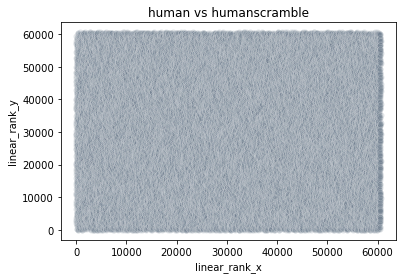

['human', 'macaque']


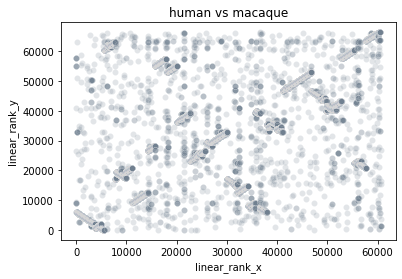

['human', 'mouse']


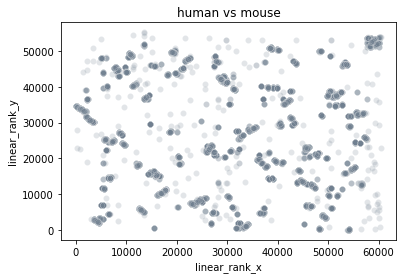

['human', 'cow']


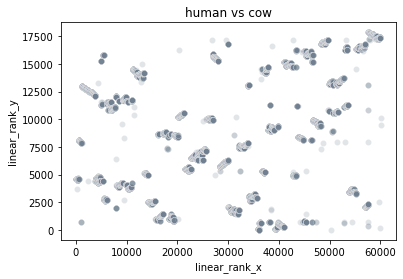

['macaque', 'cow']


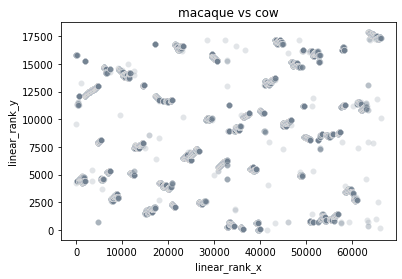

In [25]:
for pairs in species_pairs:
    print(pairs)
    if pairs[1]=='humanscramble':
        scrambled_gtf=transcript_gtfs['human'].copy(deep=True)
        scrambled_gtf['linear_rank']=list(np.random.choice(scrambled_gtf['linear_rank'],size=len(scrambled_gtf['linear_rank']),replace=False))
        merged=pd.merge(transcript_gtfs['human'], scrambled_gtf, left_index=True, right_index=True)
    else:
        merged=pd.merge(transcript_gtfs[pairs[0]], transcript_gtfs[pairs[1]], left_index=True, right_index=True)
    seaborn.scatterplot(x='linear_rank_x',y='linear_rank_y',data=merged,alpha=.2,color='slategray')
    plt.title(pairs[0]+' vs ' +pairs[1])
    plt.show()

In [23]:
transcript_gtfs

{'mouse':                  index seqname     start feature      gene_name  linear_rank
 gene_name                                                                   
 4933401J01RIK        2       1   3073253    exon  4933401J01RIK            0
 GM26206              5       1   3102016    exon        GM26206            1
 XKR4                 8       1   3213609    exon           XKR4            2
 GM18956             26       1   3252757    exon        GM18956            3
 GM37180             29       1   3365731    exon        GM37180            4
 ...                ...     ...       ...     ...            ...          ...
 MID1-PS1       1759469       Y  90753057    exon       MID1-PS1        55362
 GM21860        1759462       Y  90755394    exon        GM21860        55363
 GM47283        1759478       Y  90784738    exon        GM47283        55364
 GM21742        1759512       Y  90837413    exon        GM21742        55365
 GM21748        1759518       Y  90838869    exon      

In [45]:
merged.groupby('seqname_y')['seqname_x'].value_counts().unstack().fillna(0)

seqname_x,chr1,chr10,chr11,chr12,chr13,chr14,chr15,chr16,chr17,chr18,...,chr20,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chrUn,chrX
seqname_y,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,158.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,62.0,649.0,0.0,0.0,1.0,1.0
11,0.0,0.0,0.0,0.0,523.0,9.0,247.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,287.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13,0.0,475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,133.0,0.0,0.0
14,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,375.0,0.0,0.0,0.0
15,1.0,0.0,0.0,0.0,0.0,526.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
17,0.0,151.0,203.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,114.0,1.0,0.0,0.0,0.0,0.0,0.0


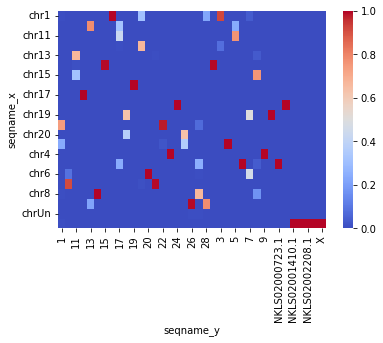

<AxesSubplot:xlabel='seqname_y', ylabel='seqname_x'>

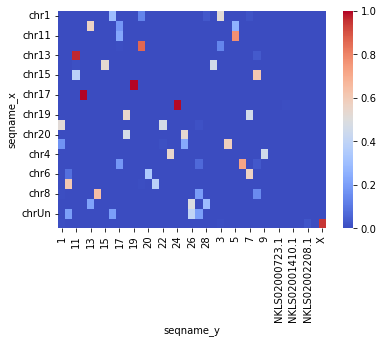

In [49]:
seaborn.heatmap(merged.groupby('seqname_y')['seqname_x'].value_counts(normalize=True).unstack().T.fillna(0),cmap='coolwarm')
plt.show()
seaborn.heatmap(merged.groupby('seqname_x')['seqname_y'].value_counts(normalize=True).unstack().fillna(0),cmap='coolwarm')


In [41]:
merged['seqname_x']=[x[0] for x in merged['seqname_x'].str.split('_')]


In [65]:
adj_xy=merged.groupby('seqname_y')['seqname_x'].value_counts(normalize=True).T.fillna(0).unstack().stack().reset_index()
adj_yx=merged.groupby('seqname_x')['seqname_y'].value_counts(normalize=True).fillna(0).unstack().stack().reset_index()

In [77]:
import networkx as nx
G=nx.from_pandas_edgelist(pd.concat([adj_xy,adj_yx],axis=0),source='seqname_y',target='seqname_x')

In [78]:
top = nx.bipartite.sets(G)[0]

pos = nx.bipartite_layout(G, top)

AmbiguousSolution: Disconnected graph: Ambiguous solution for bipartite sets.

In [63]:
adj_xy.stack().reset_index()


,seqname_x,seqname_y,0
0,chr1,1,0.005997
1,chr1,10,0.000000
2,chr1,11,0.000000
3,chr1,12,0.000000
4,chr1,13,0.000000
...,...,...,...
809,chrX,NKLS02001410.1,1.000000
810,chrX,NKLS02002206.1,1.000000
811,chrX,NKLS02002208.1,1.000000
812,chrX,NKLS02002210.1,1.000000
